In [135]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torchmetrics.regression import MeanSquaredError, R2Score

In [136]:
DATA_PATH = "./Data/"

In [137]:
train_data = pd.read_csv(DATA_PATH + 'train.csv')
train_data

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02
...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40
7494,TRAIN_7494,P사,TayCT,Brand New,NaN,AWD,1363,2,No,0,120.00
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00


In [138]:
test_data = pd.read_csv(DATA_PATH + 'test.csv')
test_data.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0
2,TEST_002,B사,i5,Brand New,NaN,RWD,7197,7,Yes,0
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1
4,TEST_004,K사,EV6,Brand New,NaN,FWD,7597,10,No,0


In [139]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [140]:
train_data['제조사'].value_counts()

제조사
H사    1237
B사    1169
K사    1164
A사    1142
T사    1109
P사    1071
V사     605
Name: count, dtype: int64

In [141]:
train_data['모델'][train_data['제조사'] == 'H사'].value_counts()

모델
ION6     379
KNE      365
ION5     353
IONIQ    140
Name: count, dtype: int64

In [142]:
train_data['차량상태'].value_counts()

차량상태
Brand New     3380
Nearly New    2059
Pre-Owned     2058
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

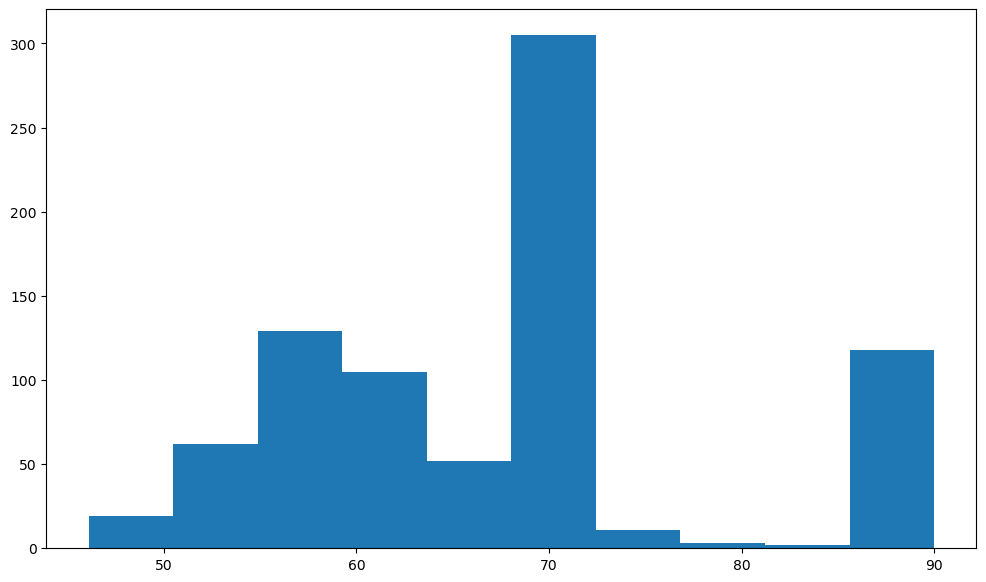

In [143]:
plt.figure(figsize = (12, 7))
plt.hist(train_data['배터리용량'][train_data['제조사'] == 'H사'])
plt.show

In [144]:
train_data['배터리용량'][train_data['제조사'] == 'H사'].mean()

67.39844044665013

In [145]:
train_data['배터리용량'] = train_data['배터리용량'].fillna(train_data.groupby('제조사')['배터리용량'].transform('mean'))

In [146]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     7497 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [147]:
pre_train_data = pd.get_dummies(train_data, columns = ['제조사', '모델', '차량상태', '구동방식', '사고이력'])
pre_train_data

,ID,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원),제조사_A사,제조사_B사,제조사_H사,제조사_K사,...,모델_i5,모델_iX,차량상태_Brand New,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_AWD,구동방식_FWD,구동방식_RWD,사고이력_No,사고이력_Yes
0,TRAIN_0000,86.077000,13642,0,2,159.66,False,False,False,False,...,False,False,False,True,False,True,False,False,True,False
1,TRAIN_0001,56.000000,10199,6,0,28.01,False,False,False,True,...,False,False,False,True,False,False,True,False,True,False
2,TRAIN_0002,91.200000,2361,7,0,66.27,True,False,False,False,...,False,False,True,False,False,True,False,False,True,False
3,TRAIN_0003,78.775598,21683,3,0,99.16,True,False,False,False,...,False,False,False,True,False,True,False,False,True,False
4,TRAIN_0004,61.018000,178205,1,0,62.02,False,True,False,False,...,True,False,False,False,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,67.398440,3773,10,0,35.95,False,False,True,False,...,False,False,True,False,False,True,False,False,True,False
7493,TRAIN_7493,46.000000,135411,2,0,23.40,False,True,False,False,...,False,False,False,False,True,False,False,True,True,False
7494,TRAIN_7494,75.265280,1363,2,0,120.00,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False
7495,TRAIN_7495,56.000000,39445,6,2,24.00,False,True,False,False,...,False,False,False,True,False,False,False,True,True,False


In [148]:
pre_train_data[pre_train_data.columns[1:]].corr()

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원),제조사_A사,제조사_B사,제조사_H사,제조사_K사,제조사_P사,...,모델_i5,모델_iX,차량상태_Brand New,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_AWD,구동방식_FWD,구동방식_RWD,사고이력_No,사고이력_Yes
배터리용량,1.000000,-0.428026,0.257751,0.010284,0.443125,0.303920,-0.230966,-0.067375,-0.389236,1.832923e-01,...,-0.082892,-0.022729,0.442318,-0.058224,-0.434942,0.323018,-0.259245,-0.150058,3.825245e-03,-3.825245e-03
주행거리(km),-0.428026,1.000000,-0.664071,-0.089586,-0.035488,-0.016008,0.004711,0.006593,-0.003576,7.806246e-03,...,0.081962,-0.162395,-0.645941,-0.152557,0.872790,-0.001958,-0.001287,0.003981,6.162968e-04,-6.162968e-04
보증기간(년),0.257751,-0.664071,1.000000,0.035294,-0.349962,-0.007338,-0.015885,0.186374,0.242283,-4.093352e-01,...,-0.106576,0.185027,0.675215,-0.070805,-0.682035,-0.140038,0.185970,-0.013992,8.011223e-03,-8.011223e-03
연식(년),0.010284,-0.089586,0.035294,1.000000,-0.058455,-0.007880,-0.007163,0.060471,-0.010986,-1.425487e-02,...,0.024510,-0.088682,-0.354174,0.596915,-0.202109,-0.039292,0.061349,-0.013776,1.044580e-02,-1.044580e-02
가격(백만원),0.443125,-0.035488,-0.349962,-0.058455,1.000000,0.148032,-0.083507,-0.376286,-0.369152,7.760593e-01,...,0.003572,0.109590,0.068253,-0.030800,-0.045296,0.404816,-0.421124,-0.084678,-4.626858e-03,4.626858e-03
제조사_A사,0.303920,-0.016008,-0.007338,-0.007880,0.148032,1.000000,-0.182200,-0.188440,-0.181739,-1.730612e-01,...,-0.102487,-0.096175,0.010543,0.008614,-0.020371,0.284665,-0.191170,-0.172306,-6.664930e-03,6.664930e-03
제조사_B사,-0.230966,0.004711,-0.015885,-0.007163,-0.083507,-0.182200,1.000000,-0.191061,-0.184266,-1.754682e-01,...,0.562494,0.527855,0.000709,0.002424,-0.003215,-0.334201,-0.193829,0.651632,-9.085758e-04,9.085758e-04
제조사_H사,-0.067375,0.006593,0.186374,0.060471,-0.376286,-0.188440,-0.191061,1.000000,-0.190577,-1.814772e-01,...,-0.107470,-0.100852,-0.033004,0.007461,0.029337,-0.093603,0.283789,-0.180686,1.478183e-02,-1.478183e-02
제조사_K사,-0.389236,-0.003576,0.242283,-0.010986,-0.369152,-0.181739,-0.184266,-0.190577,1.000000,-1.750234e-01,...,-0.103649,-0.097266,0.000158,-0.002215,0.002039,-0.318514,0.555571,-0.174260,4.493222e-04,-4.493222e-04
제조사_P사,0.183292,0.007806,-0.409335,-0.014255,0.776059,-0.173061,-0.175468,-0.181477,-0.175023,1.000000e+00,...,-0.098700,-0.092622,0.005472,-0.006954,0.000854,0.274147,-0.184106,-0.165940,4.388317e-17,7.020864e-18


In [149]:
pre_train_data = pd.get_dummies(train_data, columns = ['제조사', '모델', '차량상태', '구동방식', '사고이력'], drop_first = True)
pre_train_data

,ID,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원),제조사_B사,제조사_H사,제조사_K사,제조사_P사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,TRAIN_0000,86.077000,13642,0,2,159.66,False,False,False,True,...,True,False,False,False,False,True,False,False,False,False
1,TRAIN_0001,56.000000,10199,6,0,28.01,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
2,TRAIN_0002,91.200000,2361,7,0,66.27,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,TRAIN_0003,78.775598,21683,3,0,99.16,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,TRAIN_0004,61.018000,178205,1,0,62.02,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,67.398440,3773,10,0,35.95,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
7493,TRAIN_7493,46.000000,135411,2,0,23.40,True,False,False,False,...,False,False,True,False,False,False,True,False,True,False
7494,TRAIN_7494,75.265280,1363,2,0,120.00,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
7495,TRAIN_7495,56.000000,39445,6,2,24.00,True,False,False,False,...,False,False,True,False,False,True,False,False,True,False


In [150]:
train_target = pre_train_data['가격(백만원)']

train_feature = pre_train_data.drop(columns = ['가격(백만원)', 'ID'])
train_feature

,배터리용량,주행거리(km),보증기간(년),연식(년),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,제조사_V사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,86.077000,13642,0,2,False,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False
1,56.000000,10199,6,0,False,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
2,91.200000,2361,7,0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,78.775598,21683,3,0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,61.018000,178205,1,0,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,67.398440,3773,10,0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7493,46.000000,135411,2,0,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
7494,75.265280,1363,2,0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
7495,56.000000,39445,6,2,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False


In [151]:
test_data['배터리용량'] = test_data['배터리용량'].fillna(train_data.groupby('제조사')['배터리용량'].transform('mean'))

In [152]:
pre_test_data = pd.get_dummies(test_data, columns = ['제조사', '모델', '차량상태', '구동방식', '사고이력'], drop_first = True)
pre_test_data

,ID,배터리용량,주행거리(km),보증기간(년),연식(년),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,TEST_000,76.093000,14057,2,0,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,TEST_001,90.000000,7547,8,0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,TEST_002,78.775598,7197,7,0,True,False,False,False,False,...,False,False,False,True,False,False,False,False,True,True
3,TEST_003,68.479000,10357,7,1,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,TEST_004,62.344547,7597,10,0,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,TEST_841,64.683000,117298,2,0,False,False,False,True,False,...,True,False,False,False,False,False,True,False,False,False
842,TEST_842,55.547000,72308,0,0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
843,TEST_843,55.547000,124537,0,0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
844,TEST_844,69.646000,15629,4,0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [153]:
test_feature = pre_test_data.drop(columns = ['ID'])

test_feature

,배터리용량,주행거리(km),보증기간(년),연식(년),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,제조사_V사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,76.093000,14057,2,0,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
1,90.000000,7547,8,0,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,78.775598,7197,7,0,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,True
3,68.479000,10357,7,1,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,62.344547,7597,10,0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,64.683000,117298,2,0,False,False,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False
842,55.547000,72308,0,0,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
843,55.547000,124537,0,0,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
844,69.646000,15629,4,0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [154]:
scaling_target = train_feature.columns[:2]
scaling_target

Index(['배터리용량', '주행거리(km)'], dtype='object')

In [155]:
for col in scaling_target:
    rb_scaler = StandardScaler()
    rb_scaler.fit(train_feature[col].values.reshape(-1, 1))
    train_feature[col] = rb_scaler.transform(train_feature[col].values.reshape(-1, 1))
    test_feature[col] = rb_scaler.transform(test_feature[col].values.reshape(-1, 1))

In [156]:
train_feature

,배터리용량,주행거리(km),보증기간(년),연식(년),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,제조사_V사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,1.274318,-0.555177,0,2,False,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False
1,-1.021700,-0.617550,6,0,False,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
2,1.665397,-0.759541,7,0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0.716943,-0.409508,3,0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,-0.638636,2.426016,1,0,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,-0.151566,-0.733962,10,0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7493,-1.785081,1.650768,2,0,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
7494,0.448972,-0.777621,2,0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
7495,-1.021700,-0.087735,6,2,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False


In [157]:
train_target = pd.DataFrame(train_target)
train_target

,가격(백만원)
0,159.66
1,28.01
2,66.27
3,99.16
4,62.02
...,...
7492,35.95
7493,23.40
7494,120.00
7495,24.00


In [158]:
class CustomDataset(Dataset):
    def __init__(self, featureDF, targetDF):
        self.featureDF = featureDF
        self.targetDF = targetDF
        self.n_rows = self.featureDF.shape[0]
        self.n_cols = self.featureDF.shape[1]
    
    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        featureTS = torch.FloatTensor(self.featureDF.iloc[index].to_numpy().astype(np.float32))
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].to_numpy().astype(np.float32))

        return featureTS, targetTS

In [181]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_dim, output_dim):
        super().__init__()

        self.input_layer = nn.Linear(input_size, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        inputs = self.relu(self.input_layer(x))

        hidden = self.relu(self.hidden_layer(inputs))
        hidden = self.dropout(hidden)
        
        output = self.output_layer(hidden)

        return output

In [182]:
def testing(featureDF, targetDF, model):
    featureTS = torch.FloatTensor(featureDF.to_numpy().astype(np.float32)).to(DEVICE)
    targetTS = torch.FloatTensor(targetDF.to_numpy().astype(np.float32)).to(DEVICE)

    model.eval()

    with torch.no_grad():
        pre_val = model(featureTS)
        mse_loss_val = MSEloss(pre_val, targetTS)
        score_val = R2score(pre_val, targetTS)

    return mse_loss_val, score_val, pre_val

In [183]:
def training(model, featureDF, targetDF, optimizer, EPOCH, scheduler, DEVICE, k_folds = 5):
    
    SAVE_PATH = './saved_models/'
    os.makedirs(SAVE_PATH, exist_ok = True)    

    BREAK_CNT_LOSS = 0
    BREAK_CNT_SCORE = 0
    LIMIT_VALUE = 10
    
    MSE_LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]

    kfold = KFold(n_splits = k_folds, shuffle = True, random_state = 7)

    fold = 1
    i = 1
    
    for train_idx, val_idx in kfold.split(featureDF):
        print(f'Fold {fold}/{k_folds}')

        X_train, X_val = featureDF.iloc[train_idx], featureDF.iloc[val_idx]
        y_train, y_val = targetDF.iloc[train_idx], targetDF.iloc[val_idx]

        train_dataset = CustomDataset(X_train, y_train)
        val_dataset = CustomDataset(X_val, y_val)

        trainDL = DataLoader(train_dataset, batch_size = 32, shuffle = True)
        valDL = DataLoader(val_dataset, batch_size = 32)

        for epoch in range(1, EPOCH + 1):
            model.train()
            SAVE_WEIGHT = os.path.join(SAVE_PATH, f'model_weights_{i}.pth')

            mse_loss_total, score_total = 0, 0

            for featureTS, targetTS in trainDL:
                featureTS = featureTS.to(DEVICE)
                targetTS = targetTS.to(DEVICE)

                pre_y = model(featureTS)
                mse_loss = MSEloss(pre_y, targetTS)

                mse_loss_total += mse_loss.item()

                score = R2score(pre_y, targetTS)
                score_total += score.item()

                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            test_mse_loss, test_score, pre_val = testing(X_val, y_val, model)

            MSE_LOSS_HISTORY[1].append(test_mse_loss)
            SCORE_HISTORY[1].append(test_score)

            MSE_LOSS_HISTORY[0].append(mse_loss_total / len(trainDL))
            SCORE_HISTORY[0].append(score_total / len(trainDL))
            
            train_mse_loss = (mse_loss_total / len(trainDL))
            print(f'[{epoch} / {EPOCH}]\n - TRAIN LOSS : {MSE_LOSS_HISTORY[0][-1]}\n - TRAIN SCORE : {SCORE_HISTORY[0][-1]}')
            print(f'[{epoch} / {EPOCH}]\n - TEST LOSS : {MSE_LOSS_HISTORY[1][-1]}\n - TEST SCORE : {SCORE_HISTORY[1][-1]}')
            
            scheduler.step(train_mse_loss)

            if len(MSE_LOSS_HISTORY) >= 2:
                if MSE_LOSS_HISTORY[-1] >= MSE_LOSS_HISTORY[-2]: BREAK_CNT_LOSS += 1

            if len(MSE_LOSS_HISTORY) == 1:
                torch.save(model.state_dict(), SAVE_WEIGHT)

            else:
                if MSE_LOSS_HISTORY[-1] < min(MSE_LOSS_HISTORY[:-1]):
                    torch.save(model.state_dict(), SAVE_WEIGHT)


            if BREAK_CNT_LOSS > LIMIT_VALUE:
                print(f"{epoch} EPOCH에 학습 중단")
                break
            
            i += 1
        fold += 1

    return MSE_LOSS_HISTORY, SCORE_HISTORY

In [184]:
train_feature

,배터리용량,주행거리(km),보증기간(년),연식(년),제조사_B사,제조사_H사,제조사_K사,제조사_P사,제조사_T사,제조사_V사,...,모델_TayGTS,모델_eT,모델_i3,모델_i5,모델_iX,차량상태_Nearly New,차량상태_Pre-Owned,구동방식_FWD,구동방식_RWD,사고이력_Yes
0,1.274318,-0.555177,0,2,False,False,False,True,False,False,...,True,False,False,False,False,True,False,False,False,False
1,-1.021700,-0.617550,6,0,False,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
2,1.665397,-0.759541,7,0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0.716943,-0.409508,3,0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,-0.638636,2.426016,1,0,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,-0.151566,-0.733962,10,0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7493,-1.785081,1.650768,2,0,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
7494,0.448972,-0.777621,2,0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
7495,-1.021700,-0.087735,6,2,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False


In [185]:
EPOCH = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

input_size = 35
hidden_dim = 1024
output_dim = 1

mlp_model = MLPModel(input_size, hidden_dim, output_dim).to(DEVICE)

MSEloss = MeanSquaredError().to(DEVICE)
R2score = R2Score().to(DEVICE)

optimizer = optim.Adam(mlp_model.parameters(), lr = LR)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 10, verbose = True)

c:\Program Files\anaconda3\envs\Project_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [187]:
mse_loss, r2_score = training(mlp_model, train_feature, train_target, optimizer, EPOCH, scheduler, DEVICE)

Fold 1/5
[1 / 100]
 - TRAIN LOSS : 4.841728958043646
 - TRAIN SCORE : 0.995924472491792
[1 / 100]
 - TEST LOSS : 4.6638312339782715
 - TEST SCORE : 0.9966144561767578
[2 / 100]
 - TRAIN LOSS : 4.228830509363337
 - TRAIN SCORE : 0.9964907676615613
[2 / 100]
 - TEST LOSS : 4.633390426635742
 - TEST SCORE : 0.9966365694999695
[3 / 100]
 - TRAIN LOSS : 4.609469377614082
 - TRAIN SCORE : 0.9961021951538451
[3 / 100]
 - TEST LOSS : 3.8713724613189697
 - TEST SCORE : 0.9971897006034851
[4 / 100]
 - TRAIN LOSS : 4.314553932940706
 - TRAIN SCORE : 0.9963176925765708
[4 / 100]
 - TEST LOSS : 4.484269142150879
 - TEST SCORE : 0.9967448115348816
[5 / 100]
 - TRAIN LOSS : 4.157258636773901
 - TRAIN SCORE : 0.9966803053592114
[5 / 100]
 - TEST LOSS : 6.540915489196777
 - TEST SCORE : 0.9952518343925476
[6 / 100]
 - TRAIN LOSS : 4.145380143789535
 - TRAIN SCORE : 0.9965381961553654
[6 / 100]
 - TEST LOSS : 6.13700008392334
 - TEST SCORE : 0.9955450892448425
[7 / 100]
 - TRAIN LOSS : 4.023885288771162

KeyboardInterrupt: 

In [188]:
def predict(featureDF, model, DEVICE):
    # DataFrame -> Tensor 변환
    featureTS = torch.FloatTensor(featureDF.to_numpy().astype(np.float32)).to(DEVICE)
    
    model.eval()  # 평가 모드로 전환 (dropout 등 비활성화)
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        predictions = model(featureTS)  # 예측 수행
    
    return predictions.cpu().numpy()  # 결과를 numpy로 반환


In [189]:
test_pred = predict(test_feature, mlp_model, DEVICE)

In [190]:
submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
submission['가격(백만원)'] = test_pred

submission

,ID,가격(백만원)
0,TEST_000,131.109787
1,TEST_001,80.255913
2,TEST_002,64.103508
3,TEST_003,34.632587
4,TEST_004,47.696903
...,...,...
841,TEST_841,150.898682
842,TEST_842,38.766518
843,TEST_843,38.746567
844,TEST_844,58.793934


In [191]:
submission.to_csv(DATA_PATH + 'sample_submission.csv', index = False)